# Unit 5 - Financial Planning

In [1]:
# Initial imports
import pandas as pd
from MCForecastTools import MCSimulation
from apitools import APIcalls
from pathlib import Path
import json

%matplotlib inline

In [2]:
# Initialization of APIcalls, Load .env enviroment variables & Set alpca key and secret key
apic = APIcalls()

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# use APIcalls method to make request calls to get crypto data
crypto_data = apic.get_data_request({'BTC':btc_url,'ETH':eth_url})

# print(json.dumps(crypto_data["ETH"],indent=4))

# Fetch current BTC price
btc_rate_cad = [v["quotes"]["CAD"]["price"] for k,v in crypto_data["BTC"]["data"].items() if(v["symbol"] == "BTC")][0]

# Fetch current ETH price
eth_rate_cad = [v["quotes"]["CAD"]["price"] for k,v in crypto_data["ETH"]["data"].items() if(v["symbol"] == "ETH")][0]

# Compute current value of my crpto
my_btc_value = my_btc * btc_rate_cad
my_eth_value = my_eth * eth_rate_cad


# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $36536.38
The current value of your 5.3 ETH is $11632.73


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Format current date as ISO format
today = pd.Timestamp("2022-07-27", tz="America/New_York").isoformat()

# Set the tickers
tickers = ['AGG', 'SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# use APTcalls method to get data from alpca api
tickers_df = apic.get_alpaca_bars(tickers,timeframe,today,today)

# Reorganize the DataFrame
# Separate ticker data
AGG = tickers_df[tickers_df['symbol']=='AGG'].drop('symbol',axis=1)
SPY = tickers_df[tickers_df['symbol']=='SPY'].drop('symbol',axis=1)
# Concatenate the ticker DataFrames
tickers_df = pd.concat([AGG,SPY],axis=1,keys=['AGG','SPY'])
tickers_df

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2022-07-27 04:00:00+00:00  103.19  103.64  103.18  103.32  5098243   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2022-07-27 04:00:00+00:00       18390  103.358408  394.43  402.88  394.05   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-07-27 04:00:00+00:00  401.04  81319074      587430  398.307462

In [8]:
# Pick AGG and SPY close prices
agg_close_price = float(tickers_df['AGG']['close'])
spy_close_price = float(tickers_df['SPY']['close'])
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $103.32
Current SPY closing price: $401.04


In [9]:
# Compute the current value of shares
# YOUR CODE HERE!
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $20052.00
The current value of your 200 AGG shares is $20664.00


### Savings Health Analysis

In [10]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_wallet = my_btc_value + my_eth_value
shares_value = my_spy_value + my_agg_value
fin_assets = {'crypto': crypto_wallet , 
              'shares' : shares_value}

# Create savings DataFrame
df_savings = pd.DataFrame.from_dict(fin_assets, orient='index', columns=['amount'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,48169.10619
shares,40716.00000


array([<AxesSubplot:ylabel='amount'>], dtype=object)

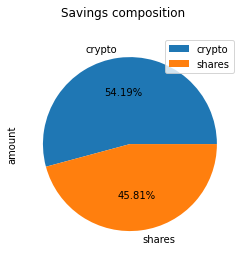

In [11]:
# Plot savings pie chart
df_savings.plot.pie(title = 'Savings composition ',
                    subplots=True,                     
                    autopct= lambda p : '{:.2f}%'.format((p))
                   )

In [12]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto_wallet + shares_value

# Validate saving health
if(emergency_fund < total_savings ):
    print("Congratulations your savings exceed your target savings")
elif(emergency_fund == total_savings ):
    print("Congratulations you met your saving target")
else:
    short = emergency_fund - total_savings
    print(f"You are ${short:0.2F} away from your personal goal")

Congratulations your savings exceed your target savings


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [13]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-07-27', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-07-27', tz='America/New_York').isoformat()

In [14]:
# Get 5 years' worth of historical data for SPY and AGG
df = apic.get_alpaca_bars(tickers,timeframe,start_date,end_date)

# Reorganize the DataFrame
# Separate ticker data
agg = df[df['symbol']=='AGG'].drop('symbol',axis = 1)
spy = df[df['symbol'] == 'SPY'].drop('symbol',axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg,spy],axis=1,keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()


AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2017-07-27 04:00:00+00:00  109.53  109.5868  109.4301  109.48  1868732   
2017-07-28 04:00:00+00:00  109.54  109.7000  109.4900  109.70  1894332   
2017-07-31 04:00:00+00:00  109.69  109.7250  109.5800  109.65  2362989   
2017-08-01 04:00:00+00:00  109.38  109.7200  109.3600  109.72  2338876   
2017-08-02 04:00:00+00:00  109.71  109.7700  109.6400  109.64  2253372   

                                                      SPY                   \
                          trade_count        vwap    open    high      low   
timestamp                                                                    
2017-07-27 04:00:00+00:00        8993  109.501792  247.96  248.00  245.680   
2017-07-28 04:00:00+00:00        8841  109.624742  246.70  247.06  246.130   
2017-07-31 04:00:00+00:00       10041  109.667698  247.38  247.48  246.530   
2017-08-01 04:00:00+00:00       10476  109.649411  247.45  247.50  246.716   
2017-08-02 04:00:00+00:00        8484  109.700965  247.47  247.60  246.370   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2017-07-27 04:00:00+00:00  247.20  70766568      255387  246.926137  
2017-07-28 04:00:00+00:00  246.91  50088359      168056  246.714676  
2017-07-31 04:00:00+00:00  246.77  65838659      164615  246.885069  
2017-08-01 04:00:00+00:00  247.32  55050401      151132  247.199252  
2017-08-02 04:00:00+00:00  247.44  47211216      178076  247.109454

In [15]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [16]:
# Printing the simulation input data
MC_thirtyyear.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2017-07-27 04:00:00+00:00  109.53  109.5868  109.4301  109.48  1868732   
2017-07-28 04:00:00+00:00  109.54  109.7000  109.4900  109.70  1894332   
2017-07-31 04:00:00+00:00  109.69  109.7250  109.5800  109.65  2362989   
2017-08-01 04:00:00+00:00  109.38  109.7200  109.3600  109.72  2338876   
2017-08-02 04:00:00+00:00  109.71  109.7700  109.6400  109.64  2253372   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-07-27 04:00:00+00:00        8993  109.501792          NaN  247.96   
2017-07-28 04:00:00+00:00        8841  109.624742     0.002009  246.70   
2017-07-31 04:00:00+00:00       10041  109.667698    -0.000456  247.38   
2017-08-01 04:00:00+00:00       10476  109.649411     0.000638  247.45   
2017-08-02 04:00:00+00:00        8484  109.700965    -0.000729  247.47   

                                                                          \
                             high      low   close    volume trade_count   
timestamp                                                                  
2017-07-27 04:00:00+00:00  248.00  245.680  247.20  70766568      255387   
2017-07-28 04:00:00+00:00  247.06  246.130  246.91  50088359      168056   
2017-07-31 04:00:00+00:00  247.48  246.530  246.77  65838659      164615   
2017-08-01 04:00:00+00:00  247.50  246.716  247.32  55050401      151132   
2017-08-02 04:00:00+00:00  247.60  246.370  247.44  47211216      178076   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-07-27 04:00:00+00:00  246.926137          NaN  
2017-07-28 04:00:00+00:00  246.714676    -0.001173  
2017-07-31 04:00:00+00:00  246.885069    -0.000567  
2017-08-01 04:00:00+00:00  247.199252     0.002229  
2017-08-02 04:00:00+00:00  247.109454     0.000485

In [17]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/pragyarastogi/Workfolder_Pragya/Bootcamp/Homework/gitrepos/finplanner/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993334,1.003253,1.002605,1.004077,1.014836,1.001233,1.011509,0.995244,1.000990,1.000045,...,0.990613,1.004827,0.988333,0.980157,1.015245,1.002026,0.999672,0.986152,0.992118,0.998463
2,0.994836,0.995701,1.004648,1.008933,1.005618,0.990744,1.023313,1.006684,1.003763,0.997359,...,0.988936,1.005447,0.982167,0.988985,1.022173,0.996539,0.999402,0.998164,0.993904,0.995449
3,1.002292,0.994072,1.004524,1.001766,0.998684,1.001444,1.022223,1.006576,1.016582,0.995558,...,1.000614,1.011423,0.988785,1.005686,1.014070,0.999563,0.997529,0.985967,1.000035,0.997678
4,0.994207,0.991869,1.001420,1.000893,0.977445,0.997130,1.013333,1.014773,1.025366,1.003536,...,1.002362,1.012696,0.996967,1.004158,1.009990,1.002880,1.004256,0.987192,0.992448,0.997615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.819107,5.849502,12.220684,3.184031,13.518952,2.863368,2.885159,15.084666,4.214914,4.500884,...,4.332123,1.984159,4.959297,3.524272,6.325101,6.830494,10.415466,3.167384,4.197471,7.557552
7557,6.729000,5.850425,12.179545,3.206170,13.732958,2.848944,2.862317,15.176155,4.177663,4.488146,...,4.333003,1.967227,4.979725,3.490001,6.423325,6.898423,10.395487,3.115354,4.240247,7.515694
7558,6.732506,5.941023,12.100152,3.211866,13.664562,2.843162,2.815621,15.366787,4.131620,4.509836,...,4.357923,1.973698,4.939421,3.504827,6.387393,6.884127,10.436766,3.123089,4.224355,7.516093
7559,6.755410,5.934595,12.080811,3.214433,13.756336,2.864289,2.808381,15.542917,4.134764,4.527407,...,4.359910,1.973756,4.949158,3.565501,6.440073,6.847277,10.563820,3.159951,4.238722,7.466789


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

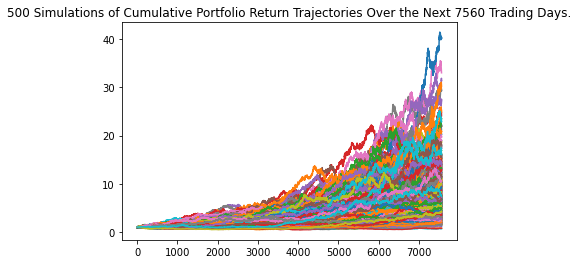

In [18]:
# Plot simulation outcomes
MC_thirtyyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

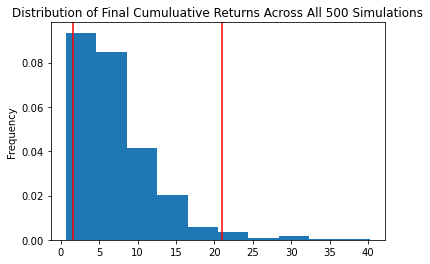

In [19]:
# Plot probability distribution and confidence intervals
MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [20]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_scr = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(mc_scr)

count           500.000000
mean              7.196197
std               5.219739
min               0.671488
25%               3.657837
50%               5.537414
75%               9.476571
max              40.246084
95% CI Lower      1.651688
95% CI Upper     20.969716
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [21]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(mc_scr[8]*initial_investment,2)
ci_upper = round(mc_scr[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $33033.76 and $419394.32


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [22]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(mc_scr[8]*initial_investment,2)
ci_upper = round(mc_scr[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $49550.63 and $629091.48


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [23]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear =  MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [24]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/pragyarastogi/Workfolder_Pragya/Bootcamp/Homework/gitrepos/finplanner/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996064,0.999060,0.997322,1.002141,1.019501,1.009512,0.985477,0.998093,0.990347,0.996496,...,1.006307,1.003699,0.995584,1.014253,0.995987,0.979182,0.999961,1.007112,0.990951,0.993762
2,1.004121,0.997702,0.986692,0.998583,1.029985,1.003500,0.996773,1.014039,0.989864,1.009694,...,1.006182,1.003829,0.999727,1.008777,1.001643,0.985596,1.001514,1.000935,0.976652,0.999569
3,1.006571,0.991592,0.973715,0.996473,1.036487,1.009695,0.994690,1.012884,0.990315,0.996261,...,1.009483,1.008057,1.007841,1.012247,1.001388,0.995501,1.006264,0.997793,0.979717,1.003550
4,1.001209,1.002868,0.973448,0.996625,1.038619,1.008410,0.996749,1.012382,0.977959,0.986107,...,1.003426,1.004215,1.027200,1.006745,0.998871,0.987832,0.999057,1.002277,0.978946,1.006472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.508211,1.327189,1.063524,1.109451,1.397089,0.826086,1.112880,1.072887,2.263687,1.235422,...,0.950044,1.438096,1.662085,1.856383,1.406348,2.313921,1.677220,1.549388,1.650458,0.958464
1257,1.510681,1.333184,1.060531,1.111934,1.394869,0.826032,1.115972,1.061896,2.221288,1.237179,...,0.957517,1.433009,1.661082,1.849433,1.400574,2.350044,1.695585,1.518183,1.640761,0.953120
1258,1.511139,1.327165,1.076167,1.102677,1.410321,0.820134,1.110842,1.052267,2.207701,1.239813,...,0.942655,1.429029,1.650837,1.858392,1.390536,2.341674,1.698473,1.519030,1.641998,0.959405
1259,1.535549,1.332650,1.075728,1.093104,1.388694,0.832246,1.105860,1.050649,2.220388,1.232053,...,0.945488,1.436222,1.681229,1.871274,1.393991,2.349373,1.706856,1.525241,1.610239,0.955272


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

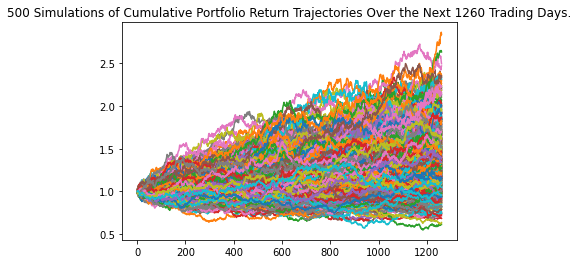

In [25]:
# Plot simulation outcomes
MC_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

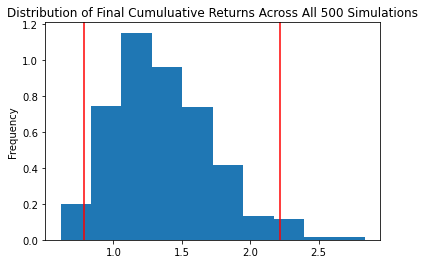

In [26]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

In [27]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_scr = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(mc_scr)

count           500.000000
mean              1.362756
std               0.365027
min               0.613525
25%               1.095047
50%               1.305930
75%               1.603480
max               2.838550
95% CI Lower      0.786719
95% CI Upper      2.214893
Name: 1260, dtype: float64


In [28]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(mc_scr[8] * initial_investment,2)
ci_upper_five = round(mc_scr[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $47203.15 and $132893.6


### Ten Years Retirement Option

In [29]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear =  MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [30]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/pragyarastogi/Workfolder_Pragya/Bootcamp/Homework/gitrepos/finplanner/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995496,1.004835,1.001454,0.997569,1.003571,0.991390,0.991078,1.012610,0.983164,0.983979,...,0.993564,1.016194,1.003096,0.997612,1.009166,1.001268,0.999200,0.984882,1.001404,0.992163
2,0.989000,1.007221,1.007352,0.993411,1.002991,0.994483,0.982040,1.006293,0.987854,0.987049,...,0.990697,1.010182,1.003280,1.003642,1.008086,0.998827,1.000613,0.978001,0.988301,0.986259
3,0.985169,1.012859,1.002844,0.990984,0.997979,0.996881,0.985652,1.014148,0.982889,0.986966,...,0.979514,1.011659,1.002501,1.004669,1.012165,0.993194,1.002796,0.961362,0.996771,0.987451
4,0.974295,1.002741,1.014697,0.985671,1.002582,0.999750,0.999144,1.000886,0.986892,0.988858,...,0.991908,1.012582,1.010961,0.994747,1.005183,1.000388,1.002151,0.968421,0.990054,0.983787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.639864,2.000350,1.429487,3.643631,2.058551,1.683982,1.545888,1.992884,2.685758,1.323662,...,1.462588,0.939400,3.017751,1.947451,2.584579,2.405617,1.270290,1.518980,8.003828,3.622699
2517,1.648136,2.002762,1.446410,3.624004,2.054001,1.692870,1.548894,2.009068,2.683600,1.337897,...,1.443312,0.948172,3.037805,1.939441,2.589509,2.407878,1.277470,1.523145,7.953326,3.639487
2518,1.681369,2.024832,1.455441,3.624029,2.043445,1.694536,1.559499,1.986101,2.682706,1.338301,...,1.429940,0.950312,3.091375,1.931071,2.613901,2.395321,1.291820,1.530572,7.952521,3.642576
2519,1.668474,2.046654,1.462385,3.599009,2.033263,1.664358,1.553480,1.980399,2.694170,1.341078,...,1.423039,0.946854,3.092898,1.931361,2.624177,2.369014,1.298463,1.510752,7.844281,3.656673


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

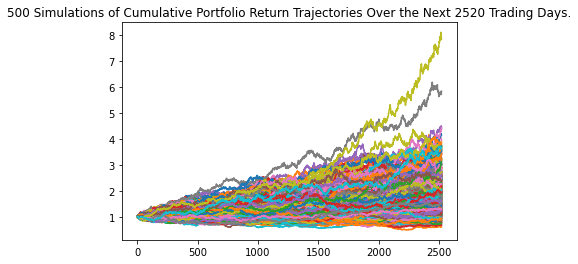

In [31]:
# Plot simulation outcomes
MC_tenyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

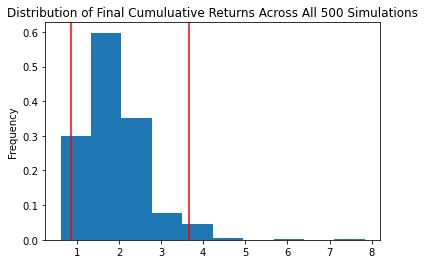

In [32]:
# Plot probability distribution and confidence intervals
MC_tenyear.plot_distribution()

In [33]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_scr = MC_tenyear.summarize_cumulative_return()

# Print summary statistics
print(mc_scr)

count           500.000000
mean              1.914168
std               0.760420
min               0.610163
25%               1.401435
50%               1.795367
75%               2.304562
max               7.839155
95% CI Lower      0.854394
95% CI Upper      3.657584
Name: 2520, dtype: float64


In [34]:
# Set initial investment
initial_investment=60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(mc_scr[8] * initial_investment,2)
ci_upper_ten = round(mc_scr[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $51263.65 and $219455.04
